# Project

Using the U.S. HDMA (Home Mortgage Disclosure Act), 2017 I am attempting to predict what loan status (Approved, denied by a lender, closed for incompleteness) an individual’s application would get. An individual could benefit by using this model before going to a lender to see if they will be approved. Lenders could use this model as a preliminary check to see if they should approve or deny a loan. With the given dataset I believe a data analytics approach is appropriate because this is a prediction problem that can be solved using details about the customer and lender.

For more detailed dataset information visit this link: https://www.consumerfinance.gov/data-research/hmda/historic-data/?geo=nationwide&records=all-records&field_descriptions=labels

Direct Dataset Link: https://files.consumerfinance.gov/hmda-historic-loan-data/hmda_2017_ca_all-records_labels.zip 


Note: Running the grid search and model training steps takes around 15 hours (on my machine)

In [1]:
#USING Python 3.8.5
#pipreqs used to genereate requirments.txt

#Date parsing,cleaning,encoding helperes
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelBinarizer,FunctionTransformer, MinMaxScaler
from sklearn_pandas import DataFrameMapper #pip install sklearn-pandas
from sklearn import preprocessing
import pickle as pkl

#Data reduction models
from sklearn.decomposition import PCA

#Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

#Model Results/gridsearch
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

## Load the data

Due to limited ram and computational power, I limited my dataset down to the state of California. This new California subset has 1,714,264 datapoints and from here on out this will be referred to as the dataset. 

Unzip the hmda_2017_ca_all-records_labels.zip and save the csv in the same folder as this python file.

Note: Alternative you can download the data direclty from: https://files.consumerfinance.gov/hmda-historic-loan-data/hmda_2017_ca_all-records_labels.zip 


In [2]:
#df = pd.read_csv("hmda_2017_nationwide_all-records_labels.csv").rename_axis('ID_OG').reset_index()
df_raw = pd.read_csv("hmda_2017_ca_all-records_labels.csv").rename_axis('ID_OG').reset_index()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (34,36,38,42,44,46,48) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Clean the Data

Drop columns that I won't be using.

In [3]:
# Keep columns that I will be using.
metadata_cols = ['ID_OG','respondent_id']
target_reason_cols = ['denial_reason_name_1','denial_reason_name_2','denial_reason_name_3']
target_col = 'action_taken_name'
keep_cols = ['agency_abbr','loan_type_name','property_type_name','loan_purpose_name','owner_occupancy_name','loan_amount_000s','preapproval_name','msamd_name','county_name','census_tract_number','applicant_ethnicity_name',
            'co_applicant_ethnicity_name','applicant_race_name_1', 'applicant_race_name_2','applicant_race_name_3','applicant_race_name_4','co_applicant_race_name_2','co_applicant_race_name_3','co_applicant_race_name_4',
            'co_applicant_race_name_5', 'applicant_sex_name','co_applicant_sex_name','applicant_income_000s','purchaser_type_name','rate_spread','hoepa_status_name','lien_status_name','population','minority_population',
            'hud_median_family_income', 'tract_to_msamd_income', 'number_of_owner_occupied_units','number_of_1_to_4_family_units']

df_pre = df_raw[metadata_cols + target_reason_cols + keep_cols + [target_col]]

Since I am only prediciting Aprroved, denined and file incomplete for indivudals. Drop rows that contain other status (ex. preapproval Approved) or rows where loan was for another insitution.

In [4]:
keep_status = ['Application denied by financial institution',
       'Loan originated','File closed for incompleteness',
       'Application approved but not accepted']
df_pre = df_pre[df_pre['action_taken_name'].isin(keep_status)]
df_pre.groupby('action_taken_name').count()['agency_abbr']


action_taken_name
Application approved but not accepted           53535
Application denied by financial institution    226258
File closed for incompleteness                  81948
Loan originated                                877753
Name: agency_abbr, dtype: int64

Drop any rows where there is nan in a required column. The following columns are ones that I thought were required
- loan_amount_000s: I believe the amount would have a big impact on predicting acceptance, so any rows without it are dropped
- applicant_income_000s: I believe that applicants income also has a big impact on predicting 
- action_taken_name: this is the target column so any rows without this should be dropped

In [5]:
def drop_rows_na_cols(df, non_na_cols):
    for c in non_na_cols:
        df = df[~df[c].isna()]

    return df

size_pre_drop = df_pre.shape[0]
non_na_cols = ['loan_amount_000s','applicant_income_000s',target_col]
df_pre = drop_rows_na_cols(df_pre,non_na_cols)

print(f"Number of rows dropped in this step: {size_pre_drop - df_pre.shape[0]} and percentage dropped: {(size_pre_drop - df_pre.shape[0])/size_pre_drop}")

Number of rows dropped in this step: 71726 and percentage dropped: 0.05786716192252645


In [6]:
#Distribution of numerical columns
df_pre.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID_OG,1167768.0,814001.624588,480424.939231,0.0,401008.750000,800852.500000,1.203142e+06,1.711900e+06
loan_amount_000s,1167768.0,400.166048,961.813447,1.0,213.000000,333.000000,4.810000e+02,4.750000e+05
census_tract_number,1164349.0,1771.558287,2354.793197,1.0,83.020000,426.200000,3.383020e+03,9.832000e+03
applicant_income_000s,1167768.0,145.531172,250.824189,1.0,68.000000,103.000000,1.610000e+02,6.078900e+04
rate_spread,38655.0,2.393003,1.337057,1.5,1.660000,1.880000,2.370000e+00,1.702000e+01
population,1164349.0,5856.179801,2877.458109,0.0,4108.000000,5356.000000,6.845000e+03,3.945400e+04
minority_population,1164349.0,54.438901,24.854502,0.0,33.730000,52.759998,7.588000e+01,1.000000e+02
hud_median_family_income,1164349.0,75246.044356,17108.911841,47300.0,63200.000000,64300.000000,8.560000e+04,1.315000e+05
tract_to_msamd_income,1164349.0,118.704548,48.723378,0.0,83.949997,111.709999,1.456600e+02,3.987000e+02
number_of_owner_occupied_units,1164349.0,1222.159539,686.812071,0.0,761.000000,1107.000000,1.529000e+03,5.229000e+03


### Impute missing values using the function below

In [7]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Impute and wrangle the data to imputate np.nans
    or cleaning categorical columns.

    :param df: a dataframe with features

    """
    mapper_impute = DataFrameMapper([
        # line by line to keep column name order
        (['ID_OG'], None),
        (['respondent_id'], None),
        (['denial_reason_name_1'], None),
        (['denial_reason_name_2'], None),
        (['denial_reason_name_3'], None),
        (['action_taken_name'], None),
        (['agency_abbr'], None), #Current Dataset has no missing values     SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
        (['loan_type_name'], None),#Current Dataset has no missing values
        (['property_type_name'], None),
        (['loan_purpose_name'], None),
        (['owner_occupancy_name'], None),
        (['loan_amount_000s'], None),
        (['preapproval_name'], None),
        (['msamd_name'], SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
        (['county_name'], SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
        (['census_tract_number'], SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)),
        (['applicant_ethnicity_name'], SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
        (['co_applicant_ethnicity_name'], SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
        (['applicant_race_name_1'], SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
        (['applicant_race_name_2'], SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
        (['applicant_race_name_3'], SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
        (['applicant_race_name_4'], SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
        (['co_applicant_race_name_2'], SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
        (['co_applicant_race_name_3'], SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
        (['co_applicant_race_name_4'], SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
        (['co_applicant_race_name_5'], SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
        (['applicant_sex_name'], SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
        (['co_applicant_sex_name'], SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
        (['applicant_income_000s'], SimpleImputer(missing_values=np.nan, strategy='median')),
        (['purchaser_type_name'], SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
        (['rate_spread'], SimpleImputer(missing_values=np.nan,  strategy='median')), #Other options Static (-1), mean or mode
        (['hoepa_status_name'], SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
        (['lien_status_name'], SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
        (['population'], SimpleImputer(missing_values=np.nan, strategy='median')), #Other options Static (-1), mean or mode
        (['minority_population'], SimpleImputer(missing_values=np.nan,  strategy='median')), #Other options Static (-1), mean or mode
        (['hud_median_family_income'], SimpleImputer(missing_values=np.nan, strategy='median')), #Other options Static (-1), mean or mode
        (['tract_to_msamd_income'], SimpleImputer(missing_values=np.nan, strategy='median')), #Other options Static (-1), mean or mode
        (['number_of_owner_occupied_units'], SimpleImputer(missing_values=np.nan,  strategy='median')), #Other options Static (-1), mean or mode
        (['number_of_1_to_4_family_units'], SimpleImputer(missing_values=np.nan, strategy='median')) #Other options Static (-1), mean or mode

    ], df_out=True)

    return mapper_impute.fit_transform(df)

In [8]:
df_clean = clean_data(df_pre)

Looking at the effects on the mean/distribution before(df_pre) and after(df_clean) filling na with median. It looks to be that for most continous columns the mean/distribution did not change by much which is good.

In [9]:
df_pre.describe()

,ID_OG,loan_amount_000s,census_tract_number,applicant_income_000s,rate_spread,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units
count,1.167768e+06,1.167768e+06,1.164349e+06,1.167768e+06,38655.000000,1.164349e+06,1.164349e+06,1.164349e+06,1.164349e+06,1.164349e+06,1.164349e+06
mean,8.140016e+05,4.001660e+02,1.771558e+03,1.455312e+02,2.393003,5.856180e+03,5.443890e+01,7.524604e+04,1.187045e+02,1.222160e+03,1.756511e+03
std,4.804249e+05,9.618134e+02,2.354793e+03,2.508242e+02,1.337057,2.877458e+03,2.485450e+01,1.710891e+04,4.872338e+01,6.868121e+02,8.887617e+02
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.500000,0.000000e+00,0.000000e+00,4.730000e+04,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.010088e+05,2.130000e+02,8.302000e+01,6.800000e+01,1.660000,4.108000e+03,3.373000e+01,6.320000e+04,8.395000e+01,7.610000e+02,1.178000e+03
50%,8.008525e+05,3.330000e+02,4.262000e+02,1.030000e+02,1.880000,5.356000e+03,5.276000e+01,6.430000e+04,1.117100e+02,1.107000e+03,1.598000e+03
75%,1.203142e+06,4.810000e+02,3.383020e+03,1.610000e+02,2.370000,6.845000e+03,7.588000e+01,8.560000e+04,1.456600e+02,1.529000e+03,2.130000e+03
max,1.711900e+06,4.750000e+05,9.832000e+03,6.078900e+04,17.020000,3.945400e+04,1.000000e+02,1.315000e+05,3.987000e+02,5.229000e+03,7.379000e+03


In [10]:
df_clean.describe()

,ID_OG,loan_amount_000s,census_tract_number,applicant_income_000s,rate_spread,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units
count,1.167768e+06,1.167768e+06,1.167768e+06,1.167768e+06,1.167768e+06,1.167768e+06,1.167768e+06,1.167768e+06,1.167768e+06,1.167768e+06,1.167768e+06
mean,8.140016e+05,4.001660e+02,1.766369e+03,1.455312e+02,1.896981e+00,5.854715e+03,5.443399e+01,7.521400e+04,1.186841e+02,1.221822e+03,1.756047e+03
std,4.804249e+05,9.618134e+02,2.353293e+03,2.508242e+02,2.599962e-01,2.873370e+03,2.481826e+01,1.709408e+04,4.865347e+01,6.858341e+02,8.875010e+02
min,0.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+00,1.500000e+00,0.000000e+00,0.000000e+00,4.730000e+04,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.010088e+05,2.130000e+02,8.202000e+01,6.800000e+01,1.880000e+00,4.114000e+03,3.374000e+01,6.320000e+04,8.401000e+01,7.620000e+02,1.179000e+03
50%,8.008525e+05,3.330000e+02,4.261700e+02,1.030000e+02,1.880000e+00,5.356000e+03,5.276000e+01,6.430000e+04,1.117100e+02,1.107000e+03,1.598000e+03
75%,1.203142e+06,4.810000e+02,3.382010e+03,1.610000e+02,1.880000e+00,6.837000e+03,7.575000e+01,8.560000e+04,1.455800e+02,1.528000e+03,2.130000e+03
max,1.711900e+06,4.750000e+05,9.832000e+03,6.078900e+04,1.702000e+01,3.945400e+04,1.000000e+02,1.315000e+05,3.987000e+02,5.229000e+03,7.379000e+03


### One-hot encode and scaler the cleaned data

In [11]:
def custom_scaler(arr_of_lst: np.array, median: float) -> np.array:
    """
    Scale skewed data to categorical bins, either:
    (1) Greater than median or
    (2) Less than or equal to median

    :param arr_of_lst: an array of lists of continuous values, for
    dollars, population.

    """
    return np.array([[0] if k[0] <= median else [1] for k in arr_of_lst])

In [12]:
def encode_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create one hot encode vectors for categorical columns and/or standard scale data
    for numerical accordingly.

    :param df: a dataframe of application data with imputed values

    """
    medianStat = df[['hud_median_family_income','tract_to_msamd_income']].describe().T['50%']
    mapper_encode = DataFrameMapper([

        (['ID_OG'], None),
        (['respondent_id'], None),
        (['denial_reason_name_1'], None),
        (['denial_reason_name_2'], None),
        (['denial_reason_name_3'], None),
        (['action_taken_name'], None),
        (['agency_abbr'], LabelBinarizer()),
        (['loan_type_name'], LabelBinarizer()),
        (['property_type_name'], LabelBinarizer()),
        (['loan_purpose_name'], LabelBinarizer()),
        (['owner_occupancy_name'], LabelBinarizer()),
        (['loan_amount_000s'], None),
        (['preapproval_name'], LabelBinarizer()),
        (['msamd_name'], LabelBinarizer()),
        (['county_name'], LabelBinarizer()),
        (['census_tract_number'], None),
        (['applicant_ethnicity_name'], LabelBinarizer()),
        (['co_applicant_ethnicity_name'], LabelBinarizer()),
        (['applicant_race_name_1'], LabelBinarizer()),
        (['applicant_race_name_2'], LabelBinarizer()),
        (['applicant_race_name_3'], LabelBinarizer()),
        (['applicant_race_name_4'], LabelBinarizer()),
        (['co_applicant_race_name_2'], LabelBinarizer()),
        (['co_applicant_race_name_3'], LabelBinarizer()),
        (['co_applicant_race_name_4'], LabelBinarizer()),
        (['co_applicant_race_name_5'], LabelBinarizer()),
        (['applicant_sex_name'], LabelBinarizer()),
        (['co_applicant_sex_name'], LabelBinarizer()),
        (['applicant_income_000s'], None),
        (['purchaser_type_name'], LabelBinarizer()),
        (['rate_spread'], None),
        (['hoepa_status_name'], LabelBinarizer()),
        (['lien_status_name'], LabelBinarizer()),
        (['population'], None),
        (['minority_population'], None),
        (['hud_median_family_income'], FunctionTransformer(custom_scaler,
                                          kw_args={"median": medianStat['hud_median_family_income']})), #Might want to just use original data instead of a median bool
        (['tract_to_msamd_income'], FunctionTransformer(custom_scaler,
                                          kw_args={"median": medianStat['tract_to_msamd_income']})),
        (['number_of_owner_occupied_units'], None),
        (['number_of_1_to_4_family_units'], None)
    ], df_out=True)

    return mapper_encode.fit_transform(df)

In [13]:
df_encoded = encode_data(df_clean)
print(f"Number of columns before encoding:{len(df_clean.columns)}\nNumber of columns after encoding:{len(df_encoded.columns)}")

Number of columns before encoding:39
Number of columns after encoding:206


# Model Data Prep
Get the train, validation and tests. As well as the X,y's for model training.
The test set will only be used as a unseen test for when I have finished parameter tunning the models.

In [14]:
def get_x_y(df, scaler = True):
    X = df.drop(metadata_cols+[target_col]+target_reason_cols,axis=1).values
    if scaler:
        #X = MinMaxScaler().fit_transform(X)
        X = preprocessing.scale(X)

    y = df[target_col].values

    return X,y

In [15]:
#random state set so this won't change each run, Also this split is stratified
df_encoded_train_val, df_encoded_test = train_test_split(df_encoded, test_size=0.1, random_state=123, 
                                                         stratify=df_encoded[target_col]) 

In [16]:
X_train_val, y_train_val = get_x_y(df_encoded_train_val)
X_test, y_test = get_x_y(df_encoded_test)

del df_encoded_train_val #to save memory

In [17]:
pca = PCA(n_components=25) #used to be 10
X_train_val_small = pca.fit_transform(X_train_val)
X_test_small = pca.fit_transform(X_test)


# Parameter Tunning
I used grid search to find optimal parameters for each model. Due to the limitations of my hardware, I was only able to test a small subset of parameter variations.

In [18]:
def get_models(model_type = "Decision Tree",  params={}):
    """ Return pointer to model with given params 
    :param model_type: Model to initialize
    :param params: Params to initialize model with
    """
    if model_type == "Decision Tree":
        mdl = DecisionTreeClassifier(**params)
    elif model_type == "Logistic Regression":
        mdl = LogisticRegression(**params)
    elif model_type == "Naive Bayes":
        mdl = BernoulliNB(**params)
    elif model_type == "KNN":
        mdl = KNeighborsClassifier(**params)
    elif model_type == "Neural network":
        mdl = MLPClassifier(**params)
    elif model_type == "SVM":
        mdl = SVC(**params)
    else:
        raise Exception("Model Type not recognized. Try one of the following: ['Decision Tree','Logistic Regression','Naive Bayes','KNN','Neural network','SVM']")

    return mdl

In [19]:
def run_models_w_grid_search(mdl, X, y, parameters):
    clf = GridSearchCV(mdl, parameters, cv=3,n_jobs=-1,verbose=2)
    clf.fit(X,y)
    return clf

grid_results_dfs = {}

NOTE: Running this block takes atleast 16 hours on my laptop (I ran it over night and throughout the day).

In [20]:
#GRID SEARCH step - Naive Bayes skipped
models_params_grid = {"Decision Tree":{'criterion':['gini'],'max_depth':[None,10,25,50]}, #Using gini since its faster and not much of a difference in scores
                      "Logistic Regression":{'penalty':['l2'],'solver':['lbfgs'], 'C': [0.001,0.01,0.1,1],'max_iter':[1000]},
                     "KNN": {'n_neighbors':[5,10,15]},
                      "Neural network": { 'hidden_layer_sizes': [(10,20,10), (10,10,10), (20,10,5)],
                                           'activation': ['tanh', 'relu'],
                                           'solver': ['sgd', 'adam'],
                                           'alpha': [0.0001, 0.05],
                                           'learning_rate': ['constant','adaptive'],
                                           'max_iter':[200]},
                      #"SVM": {'kernel':('linear', 'rbf'), 'C':[1, 10]}
                     }
        

for mdl_type,params in models_params_grid.items():
    print(f"\n---- Model Type: {mdl_type}-----")
    mdl = get_models(mdl_type)
    if mdl_type in ['KNN']:
        clf = run_models_w_grid_search(mdl, X_train_val_small, y_train_val, params)
    else:
        clf = run_models_w_grid_search(mdl, X_train_val, y_train_val, params)
    grid_results_dfs[mdl_type] = pd.DataFrame(clf.cv_results_)
    print(grid_results_dfs[mdl_type].to_string())



---- Model Type: Decision Tree-----
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:  2.9min remaining:  8.6min
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  3.2min remaining:   38.8s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.3min finished


   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_criterion param_max_depth                                    params  split0_test_score  split1_test_score  split2_test_score  mean_test_score  std_test_score  rank_test_score
0     184.355548      4.922018         2.710743        0.825086            gini            None  {'criterion': 'gini', 'max_depth': None}           0.762299           0.761282           0.761436         0.761673        0.000447                4
1     155.908494      6.593873         5.021175        1.087320            gini              10    {'criterion': 'gini', 'max_depth': 10}           0.813291           0.813305           0.812691         0.813095        0.000286                1
2     182.243585      5.141327         2.956693        1.084966            gini              25    {'criterion': 'gini', 'max_depth': 25}           0.787238           0.789307           0.787129         0.787892        0.001002                2
3     186.369032    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed: 11.9min remaining: 35.7min
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 20.8min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 21.6min finished


   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_max_iter param_penalty param_solver                                                              params  split0_test_score  split1_test_score  split2_test_score  mean_test_score  std_test_score  rank_test_score
0     675.300604    180.070227         4.558817        0.404909   0.001           1000            l2        lbfgs  {'C': 0.001, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}           0.805364           0.804513           0.804621         0.804833        0.000378                4
1     794.481125    127.650286         3.434471        0.620300    0.01           1000            l2        lbfgs   {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}           0.805795           0.804898           0.805067         0.805253        0.000389                3
2    1200.693407     58.087237         2.222346        0.391902     0.1           1000            l2        lbfgs    {'C': 0.1, 'max_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed: 14.7min remaining:  7.3min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 16.6min finished


   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_n_neighbors               params  split0_test_score  split1_test_score  split2_test_score  mean_test_score  std_test_score  rank_test_score
0      21.853885      1.359578       609.430161       31.576058                 5   {'n_neighbors': 5}           0.751766           0.752556           0.754015         0.752779        0.000931                3
1      22.936045      1.017744       805.589381       33.495494                10  {'n_neighbors': 10}           0.763118           0.763711           0.764619         0.763816        0.000617                2
2      22.747793      1.039565       918.214784       37.235375                15  {'n_neighbors': 15}           0.766609           0.766238           0.766857         0.766568        0.000255                1

---- Model Type: Neural network-----
Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 55.2min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 277.1min finished


    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_activation param_alpha param_hidden_layer_sizes param_learning_rate param_max_iter param_solver                                                                                                                                       params  split0_test_score  split1_test_score  split2_test_score  mean_test_score  std_test_score  rank_test_score
0     4858.679597   2389.784801        10.535156        2.255036             tanh      0.0001             (10, 20, 10)            constant            200          sgd   {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 20, 10), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'sgd'}           0.816040           0.815357           0.814503         0.815300        0.000628               25
1     1705.776983    506.340780         8.459095        1.524864             tanh      0.0001             (10, 20, 10)            constant            200         adam  {'

In [21]:
# write python dict to a file. DON'T RUN UNLESS FULL GRID SEARCH WAS RUN
if grid_results_dfs != {}:
    output = open('myfileV2.pkl', 'wb')
    pkl.dump(grid_results_dfs, output)
    output.close()


Grid Search results: A data frame is printed with scores for each model type

In [38]:
# read python dict back from the file
pkl_file = open('myfileV2.pkl', 'rb')
mydict2 = pkl.load(pkl_file)
pkl_file.close()
for k in grid_results_dfs:
    print(f"\n------{k}------")
    display(grid_results_dfs[k])



------Decision Tree------


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,184.355548,4.922018,2.710743,0.825086,gini,None,"{'criterion': 'gini', 'max_depth': None}",0.762299,0.761282,0.761436,0.761673,0.000447,4
1,155.908494,6.593873,5.021175,1.087320,gini,10,"{'criterion': 'gini', 'max_depth': 10}",0.813291,0.813305,0.812691,0.813095,0.000286,1
2,182.243585,5.141327,2.956693,1.084966,gini,25,"{'criterion': 'gini', 'max_depth': 25}",0.787238,0.789307,0.787129,0.787892,0.001002,2
3,186.369032,1.167061,2.575447,0.268828,gini,50,"{'criterion': 'gini', 'max_depth': 50}",0.762273,0.760985,0.761919,0.761726,0.000543,3



------Logistic Regression------


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,675.300604,180.070227,4.558817,0.404909,0.001,1000,l2,lbfgs,"{'C': 0.001, 'max_iter': 1000, 'penalty': 'l2'...",0.805364,0.804513,0.804621,0.804833,0.000378,4
1,794.481125,127.650286,3.434471,0.620300,0.01,1000,l2,lbfgs,"{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2',...",0.805795,0.804898,0.805067,0.805253,0.000389,3
2,1200.693407,58.087237,2.222346,0.391902,0.1,1000,l2,lbfgs,"{'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', ...",0.805824,0.804970,0.805107,0.805300,0.000375,2
3,1129.822945,213.614867,3.222764,2.346777,1,1000,l2,lbfgs,"{'C': 1, 'max_iter': 1000, 'penalty': 'l2', 's...",0.805844,0.804970,0.805112,0.805309,0.000383,1



------KNN------


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,21.853885,1.359578,609.430161,31.576058,5,{'n_neighbors': 5},0.751766,0.752556,0.754015,0.752779,0.000931,3
1,22.936045,1.017744,805.589381,33.495494,10,{'n_neighbors': 10},0.763118,0.763711,0.764619,0.763816,0.000617,2
2,22.747793,1.039565,918.214784,37.235375,15,{'n_neighbors': 15},0.766609,0.766238,0.766857,0.766568,0.000255,1



------Neural network------


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,4858.679597,2389.784801,10.535156,2.255036,tanh,0.0001,"(10, 20, 10)",constant,200,sgd,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.816040,0.815357,0.814503,0.815300,0.000628,25
1,1705.776983,506.340780,8.459095,1.524864,tanh,0.0001,"(10, 20, 10)",constant,200,adam,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.817304,0.815614,0.815582,0.816167,0.000804,5
2,5652.081582,4599.899240,12.127898,2.352047,tanh,0.0001,"(10, 20, 10)",adaptive,200,sgd,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.816616,0.816125,0.814338,0.815693,0.000979,13
3,1770.401493,429.128994,9.235300,3.103334,tanh,0.0001,"(10, 20, 10)",adaptive,200,adam,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.816716,0.815928,0.815360,0.816001,0.000556,7
4,2865.522179,2725.490913,7.021217,1.099631,tanh,0.0001,"(10, 10, 10)",constant,200,sgd,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.815711,0.814415,0.814309,0.814812,0.000638,34
5,563.512311,62.478963,7.382921,1.160036,tanh,0.0001,"(10, 10, 10)",constant,200,adam,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.815985,0.815916,0.814361,0.815421,0.000750,20
6,1182.655507,166.155432,39.372203,42.443071,tanh,0.0001,"(10, 10, 10)",adaptive,200,sgd,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.815024,0.816028,0.814863,0.815305,0.000515,24
7,457.382071,132.299487,9.235632,1.580995,tanh,0.0001,"(10, 10, 10)",adaptive,200,adam,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.816454,0.814706,0.815405,0.815522,0.000718,18
8,973.243855,263.382945,11.114275,0.610104,tanh,0.0001,"(20, 10, 5)",constant,200,sgd,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.816248,0.815306,0.815177,0.815577,0.000477,16
9,695.238071,243.170400,11.845321,3.104368,tanh,0.0001,"(20, 10, 5)",constant,200,adam,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.815574,0.815680,0.815537,0.815597,0.000060,15


# Run Models with final Parameters
Run the models with the best parameters extracted from grid search.
NOTE: Running this section takes atleast 2 hours on my laptop (I ran it over night). With KNN and NN begin the slowest

In [23]:
def train_evalute_models(mdl, X, y, print_avg_fold_scores=True):
    """ Given a model and X,y data run(train/validate set) and print the 5 fold cross validation scores
    :param mdl: model to run
    :param X: features Data
    :param y: class targets
    :param print_avg_fold_scores: if true show the average score across the folds
    """
    #USING STRATIFIED KFOLD
    scores = cross_validate(mdl, X, y,n_jobs=-1, cv=5, scoring=['precision_weighted','recall_weighted', 'f1_weighted'], return_train_score=True, return_estimator=True) #USES stratfied KFOLD when cv number is set
    scores = {k.replace('test_','validation_'):v for k,v in scores.items()}
    scores_to_print = {k:v for k,v in scores.items() if k != 'estimator'}
    print("".join(f"{k}: {np.mean(v)}\n" if print_avg_fold_scores else f"{k}: {v}\n" for k,v in scores_to_print.items() ))
    return scores


In [24]:
#Final Results and training
final_model_params = {"Decision Tree":{'criterion':'gini','max_depth':10},
                      "Logistic Regression":{'n_jobs':-1,'penalty':'l2','solver':'lbfgs', 'C': 1, 'max_iter':1000},
                      "Naive Bayes" : {},
                      'KNN': {'n_jobs':-1,'n_neighbors':5},
                      'Neural network': {'hidden_layer_sizes': (20,10,5),
                                            'activation': 'relu',
                                            'solver': 'adam',
                                            'alpha': 0.001,
                                            'learning_rate': 'adaptive',
                                            'max_iter':1000},
                      #"SVM": {'kernel':'linear', 'C':10}
                      }
final_scores = {}
for mdl_type,params in final_model_params.items():
    print(f"---- Model Type: {mdl_type}-----")
    mdl = get_models(mdl_type, params)
    if mdl_type in ['KNN']:
        final_scores[mdl_type] = train_evalute_models(mdl, X_train_val_small, y_train_val)
    else:
        final_scores[mdl_type] = train_evalute_models(mdl, X_train_val, y_train_val)
        

---- Model Type: Decision Tree-----
fit_time: 69.2485957622528
score_time: 5.682601690292358
validation_precision_weighted: 0.8115778044980138
train_precision_weighted: 0.8135643547701934
validation_recall_weighted: 0.8131239941835215
train_recall_weighted: 0.8139061132355729
validation_f1_weighted: 0.7853610101962274
train_f1_weighted: 0.786163344373581

---- Model Type: Logistic Regression-----
fit_time: 817.3432823657989
score_time: 5.200206279754639
validation_precision_weighted: 0.7866220061281488
train_precision_weighted: 0.7875847509994018
validation_recall_weighted: 0.8052219277625404
train_recall_weighted: 0.8054588478199409
validation_f1_weighted: 0.7725349918553412
train_f1_weighted: 0.772775639445875

---- Model Type: Naive Bayes-----
fit_time: 24.918556213378906
score_time: 9.064157962799072
validation_precision_weighted: 0.7593961189206764
train_precision_weighted: 0.759652108533639
validation_recall_weighted: 0.7528209098298866
train_recall_weighted: 0.7529700539147643
v

In [25]:
final_scores

{'Decision Tree': {'fit_time': array([70.54034209, 71.20556092, 69.78635716, 69.55497599, 65.15574265]),
  'score_time': array([5.55613947, 5.85035348, 5.80746841, 5.85134983, 5.34769726]),
  'estimator': (DecisionTreeClassifier(max_depth=10),
   DecisionTreeClassifier(max_depth=10),
   DecisionTreeClassifier(max_depth=10),
   DecisionTreeClassifier(max_depth=10),
   DecisionTreeClassifier(max_depth=10)),
  'validation_precision_weighted': array([0.81430637, 0.81206898, 0.81316412, 0.8065619 , 0.81178765]),
  'train_precision_weighted': array([0.81394266, 0.81425473, 0.81496987, 0.80867906, 0.81597546]),
  'validation_recall_weighted': array([0.81335306, 0.81335217, 0.81358053, 0.81300488, 0.81232933]),
  'train_recall_weighted': array([0.81332839, 0.81421587, 0.81400178, 0.81390069, 0.81408385]),
  'validation_f1_weighted': array([0.78592913, 0.78610272, 0.78499278, 0.78410185, 0.78567856]),
  'train_f1_weighted': array([0.78587666, 0.78657164, 0.78547096, 0.78529736, 0.7876001 ])},
 

# Run test set on final models
NOTE: Running this section takes atleast 3 hours on my laptop (I ran it over night). With KNN being the slowest.

In [26]:
def test_evalute_models(mdls, X, y, print_avg_fold_scores=True):
    """ Given a model and X,y data run(test set) and print the 5 fold cross test scores
    :param mdl: model to run
    :param X: features Data
    :param y: class targets
    :param print_avg_fold_scores: if true show the average score across the folds
    """
    scores = {'test_precision_weighted': np.array([]),
     'test_recall_weighted': np.array([]),
     'test_f1-score_weighted': np.array([])}
    for mdl in mdls:
        mdl = mdl
        y_pred = mdl.predict(X)
        curr_scores = classification_report(y,y_pred,output_dict=True)['weighted avg']
        curr_scores = {"test_"+k+"_weighted":v for k,v in curr_scores.items() if k !='support'}
        for k,v in curr_scores.items():
            scores[k] = np.append(scores[k],np.array([v]))
    scores['test_f1_weighted'] = scores.pop('test_f1-score_weighted')
    scores
        
    print("".join(f"{k}: {np.mean(v)}\n" if print_avg_fold_scores else f"{k}: {v}\n" for k,v in scores.items() ))
    return scores


In [27]:
for mdl_type, mdl_info in final_scores.items():
    print(mdl_type)
    if mdl_type in ['KNN']:
        curr_scores = test_evalute_models(mdl_info['estimator'], X_test_small, y_test)
    else:
        curr_scores = test_evalute_models(mdl_info['estimator'], X_test, y_test)
        
    final_scores[mdl_type].update(curr_scores)

# write python dict to a file
output = open('finalscoresmyfile.pkl', 'wb')
pkl.dump(final_scores, output)
output.close()

Decision Tree
test_precision_weighted: 0.7795802665825413
test_recall_weighted: 0.7950623838598354
test_f1_weighted: 0.7702869676517952

Logistic Regression
test_precision_weighted: 0.7856034664008693
test_recall_weighted: 0.8036925079424886
test_f1_weighted: 0.7752798260834223

Naive Bayes
test_precision_weighted: 0.757038875143927
test_recall_weighted: 0.7506735059129795
test_f1_weighted: 0.7430454986983965

KNN
test_precision_weighted: 0.5703632579273628
test_recall_weighted: 0.6074997645084219
test_f1_weighted: 0.5874700940333236

Neural network
test_precision_weighted: 0.7966360822282684
test_recall_weighted: 0.7843633592231347
test_f1_weighted: 0.7698399189779415



# Graph Results

In [28]:
final_scores

{'Decision Tree': {'fit_time': array([70.54034209, 71.20556092, 69.78635716, 69.55497599, 65.15574265]),
  'score_time': array([5.55613947, 5.85035348, 5.80746841, 5.85134983, 5.34769726]),
  'estimator': (DecisionTreeClassifier(max_depth=10),
   DecisionTreeClassifier(max_depth=10),
   DecisionTreeClassifier(max_depth=10),
   DecisionTreeClassifier(max_depth=10),
   DecisionTreeClassifier(max_depth=10)),
  'validation_precision_weighted': array([0.81430637, 0.81206898, 0.81316412, 0.8065619 , 0.81178765]),
  'train_precision_weighted': array([0.81394266, 0.81425473, 0.81496987, 0.80867906, 0.81597546]),
  'validation_recall_weighted': array([0.81335306, 0.81335217, 0.81358053, 0.81300488, 0.81232933]),
  'train_recall_weighted': array([0.81332839, 0.81421587, 0.81400178, 0.81390069, 0.81408385]),
  'validation_f1_weighted': array([0.78592913, 0.78610272, 0.78499278, 0.78410185, 0.78567856]),
  'train_f1_weighted': array([0.78587666, 0.78657164, 0.78547096, 0.78529736, 0.7876001 ]),
  

Convert scores to dataframe

In [29]:
#Convert scores to dataframe
scores_df = pd.DataFrame({k:dict([(k2,v2) for k2,v2 in v.items() if k2 != 'estimator']) for k,v in final_scores.items() }).T
scores_df['merge_col'] = 1  
temp_cv_df = pd.DataFrame([1,2,3,4,5],columns=['cv'])
temp_cv_df['merge_col'] = 1  
scores_df = scores_df.reset_index().rename(columns={'index':'model'}).merge(temp_cv_df,on='merge_col').drop(columns=['merge_col'])


In [30]:
cols_with_time = ['fit_time', 'score_time']
train_cols_with_scores = [
 'train_f1_weighted',
 'train_precision_weighted',
 'train_recall_weighted']
validation_cols_with_scores = [
 'validation_f1_weighted',
 'validation_precision_weighted',
 'validation_recall_weighted']
test_cols_with_scores = [
 'test_f1_weighted',
 'test_precision_weighted',
 'test_recall_weighted']
for c in train_cols_with_scores + validation_cols_with_scores +test_cols_with_scores+ cols_with_time:
    scores_df.loc[:,c] = scores_df.apply(lambda row:row[c][row['cv']-1],axis=1)
    
scores_df = scores_df[['model', 'cv'] + train_cols_with_scores + validation_cols_with_scores + test_cols_with_scores + cols_with_time]  


Average Scores

In [31]:
scores_df.groupby(['model']).mean().drop(columns=['cv']).T

model,Decision Tree,KNN,Logistic Regression,Naive Bayes,Neural network
train_f1_weighted,0.786163,0.821356,0.772776,0.745368,0.791280
train_precision_weighted,0.813564,0.822477,0.787585,0.759652,0.810613
train_recall_weighted,0.813906,0.827115,0.805459,0.752970,0.817584
validation_f1_weighted,0.785361,0.747609,0.772535,0.745180,0.790031
validation_precision_weighted,0.811578,0.743806,0.786622,0.759396,0.807704
validation_recall_weighted,0.813124,0.755139,0.805222,0.752821,0.816361
test_f1_weighted,0.770287,0.587470,0.775280,0.743045,0.769840
test_precision_weighted,0.779580,0.570363,0.785603,0.757039,0.796636
test_recall_weighted,0.795062,0.607500,0.803693,0.750674,0.784363
fit_time,69.248596,23.703604,817.343282,24.918556,321.816507


### Graphs

Text(0.5, 1.0, 'Training scores across 5 folds')

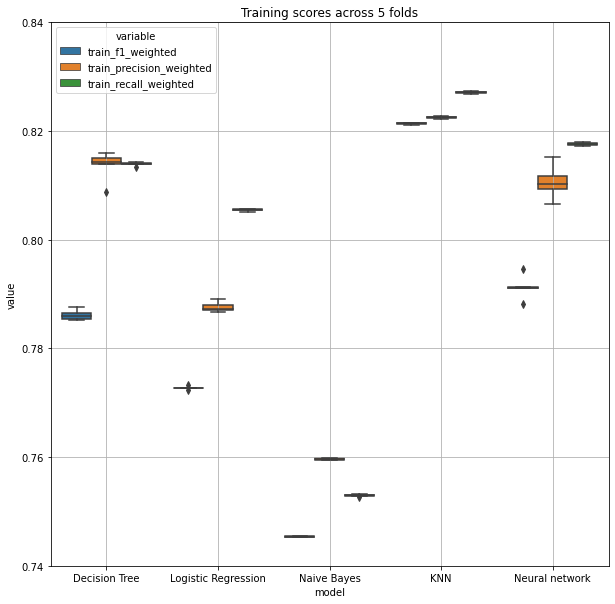

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
df_plot = scores_df.drop(columns=['cv']).melt(id_vars='model', value_vars=train_cols_with_scores)
sns.boxplot(x='model', y='value', hue='variable', data=df_plot, ax=ax)
ax.yaxis.grid(True) # Show the horizontal gridlines
ax.xaxis.grid(True) # Show the vertical gridlines
ax.set_ylim([0.74,0.84])  
ax.set_title('Training scores across 5 folds')


Text(0.5, 1.0, 'Validation scores across 5 folds')

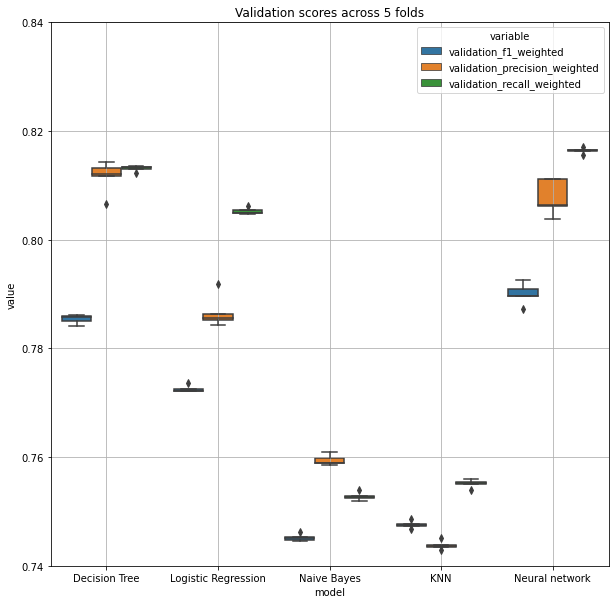

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
df_plot = scores_df.drop(columns=['cv']).melt(id_vars='model', value_vars=validation_cols_with_scores)
sns.boxplot(x='model', y='value', hue='variable', data=df_plot, ax=ax)
ax.yaxis.grid(True) # Show the horizontal gridlines
ax.xaxis.grid(True) # Show the vertical gridlines
ax.set_ylim([0.74,0.84])  
ax.set_title('Validation scores across 5 folds')



Text(0.5, 1.0, 'Test scores across 5 folds')

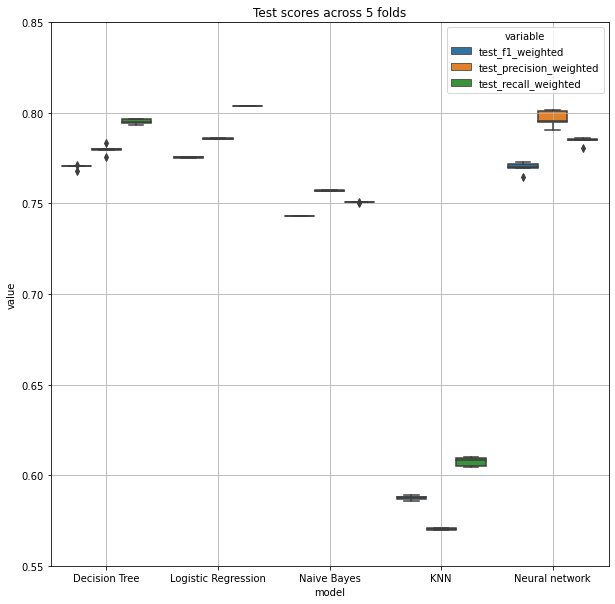

In [35]:
fig, ax = plt.subplots(figsize=(10,10))
df_plot = scores_df.drop(columns=['cv']).melt(id_vars='model', value_vars=test_cols_with_scores)
sns.boxplot(x='model', y='value', hue='variable', data=df_plot, ax=ax)
ax.yaxis.grid(True) # Show the horizontal gridlines
ax.xaxis.grid(True) # Show the vertical gridlines
ax.set_ylim([0.55,0.85])  
ax.set_title('Test scores across 5 folds')